<a href="https://colab.research.google.com/github/anastasiashapoval/machine-learning/blob/main/%D0%BB%D1%8012_%D0%BC%D0%BD_%D1%88%D0%B0%D0%BF%D0%BE%D0%B2%D0%B0%D0%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moazeldsokyx_dogs_vs_cats_path = kagglehub.dataset_download('moazeldsokyx/dogs-vs-cats')

print('Data source import complete.')

Data source import complete.


In [ ]:
moazeldsokyx_dogs_vs_cats_path

'/kaggle/input/dogs-vs-cats'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # 0 = all messages, 3 = only errors
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
train_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/train'
val_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/validation'
test_dir =moazeldsokyx_dogs_vs_cats_path+'/dataset/test'

In [ ]:
class_names = ['Cat', 'Dog']
# Генератор для тренування з аугментацією + нормалізацією для VGG16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Генератор для валідації і тесту — тільки нормалізація

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Генератор для тренувального набору

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Рекомендований розмір для VGG16
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Генератор для валідаційного набору

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Генератор для тестового набору

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


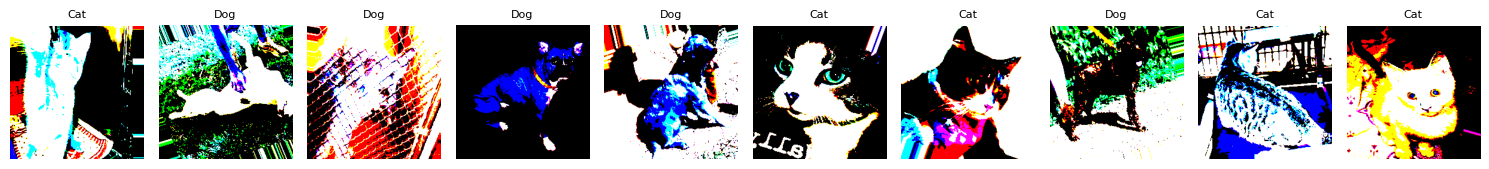

In [ ]:
# Отримуємо новий набір зображень
images, labels = next(train_generator)

# Випадкові індекси для 10 зображень
indices = np.random.choice(len(images), size=10, replace=False)

# Візуалізація
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(class_names[int(labels[idx])], fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,           # Ми додаємо свої класифікатори
    input_shape=(224, 224, 3)
)

# Заморожуємо всі шари базової VGG16
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Слідкуємо за валідаційною втратою
    patience=5,               # Скільки епох чекати без покращення
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Зменшення LR у 5 разів
    patience=3,               # Якщо за 3 епохи немає покращення
    min_lr=1e-6               # Мінімально допустимий learning rate
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 373s 596ms/step - accuracy: 0.9685 - loss: 0.1057 - val_accuracy: 0.9824 - val_loss: 0.0698
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 309s 494ms/step - accuracy: 0.9779 - loss: 0.0653 - val_accuracy: 0.9854 - val_loss: 0.0615
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 308s 493ms/step - accuracy: 0.9791 - loss: 0.0565 - val_accuracy: 0.9808 - val_loss: 0.0619
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 498ms/step - accuracy: 0.9843 - loss: 0.0469 - val_accuracy: 0.9862 - val_loss: 0.0544
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 315s 503ms/step - accuracy: 0.9832 - loss: 0.0449 - val_accuracy: 0.9832 - val_loss: 0.0594
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 310s 496ms/step - accuracy: 0.9858 - loss: 0.0403 - val_accuracy: 0.9854 - val_loss: 0.0589
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 319s 492ms/step - accuracy: 0.9861 - loss: 0.0402 - val_accuracy: 0.9824 - val_loss: 0.0666
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 307s 492ms/step - accuracy: 0.9869 -

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
model.save("/content/drive/MyDrive/vgg16_cats_dogs.keras")

Mounted at /content/drive


In [ ]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Точність: {acc:.2%}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 109s 280ms/step - accuracy: 0.9806 - loss: 0.0620
Точність: 98.56%


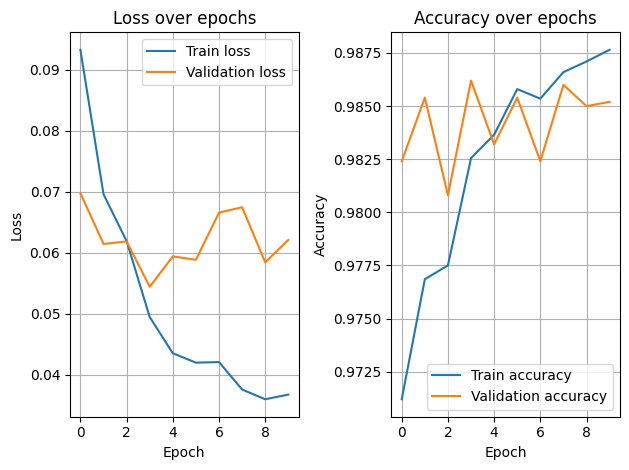

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


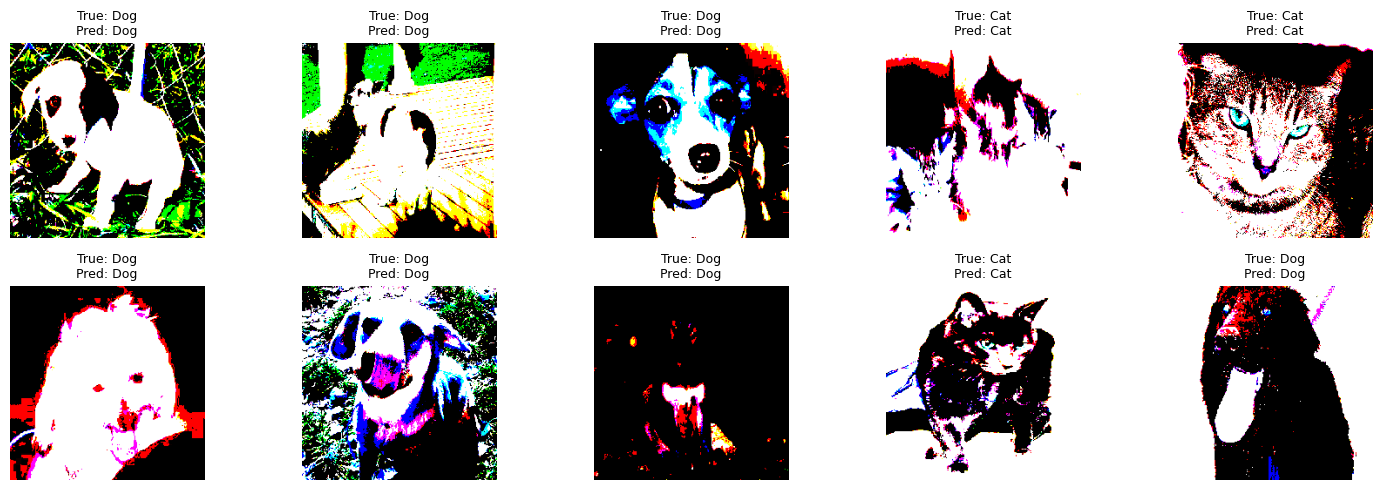

In [ ]:
# Отримуємо batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Назви класів
class_names = ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Завантаження базової VGG16 без класифікатора
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# ❄️ Заморожуємо тільки нижні шари, а верхні розморозимо для fine-tuning
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

# 🔁 Замість Flatten краще використовувати GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Створення фінальної моделі
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 525ms/step - accuracy: 0.9331 - loss: 0.2020 - val_accuracy: 0.9852 - val_loss: 0.0463
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 390s 546ms/step - accuracy: 0.9770 - loss: 0.0637 - val_accuracy: 0.9850 - val_loss: 0.0482
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 516ms/step - accuracy: 0.9834 - loss: 0.0427 - val_accuracy: 0.9828 - val_loss: 0.0594
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 381s 514ms/step - accuracy: 0.9873 - loss: 0.0335 - val_accuracy: 0.9834 - val_loss: 0.0633
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 518ms/step - accuracy: 0.9898 - loss: 0.0300 - val_accuracy: 0.9876 - val_loss: 0.0484


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
model.save("/content/drive/MyDrive/vgg16_cats_dogs_finetuned.keras")

Mounted at /content/drive


In [ ]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Точність: {acc:.2%}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 63s 162ms/step - accuracy: 0.9860 - loss: 0.0449
Точність: 98.76%


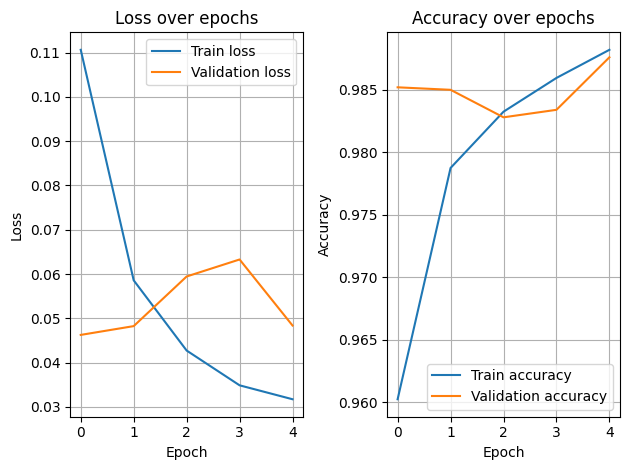

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


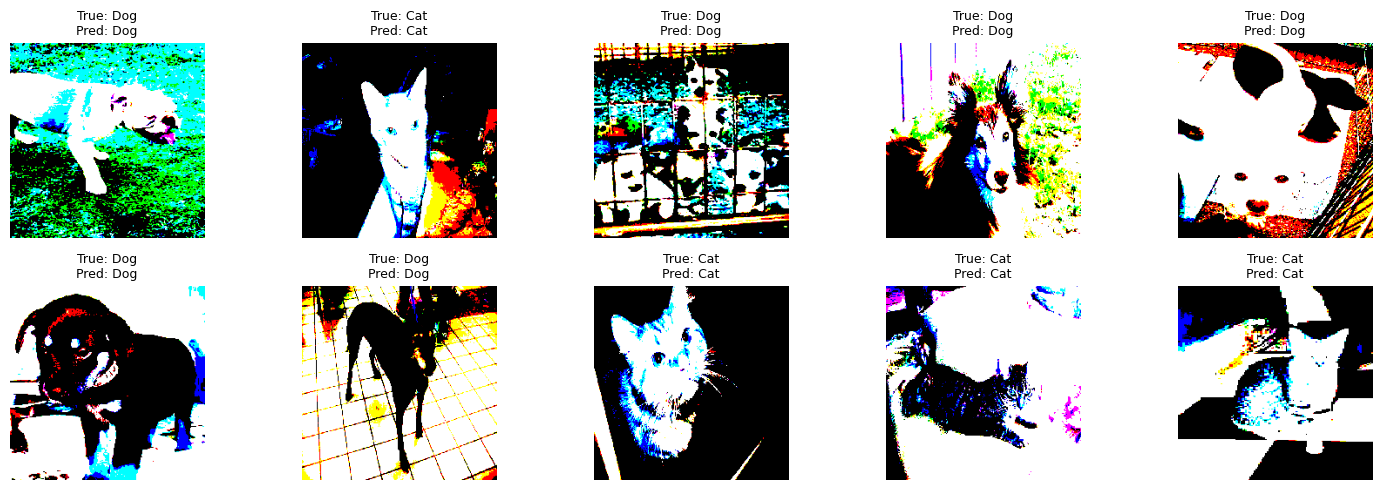

In [ ]:
# Отримуємо batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Назви класів
class_names = ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

Висновок: під час лабораторної роботи було використано претреновану згорткову модель VGG16 для класифікації зображень та проведено її донавчання на прикладі датасету з котами та собаками. Модель показала точність в 98.56%. Криві навчання також показали відмінний результат. Було виведено 10 зображень зі справжніми та передбаченими класами, класи співпали у 10/10 випадках. Після виконання тюнінгу моделі, вона показала точність в 98.76%. Криві навчання та передбачення класів також відобразили високу точність.